# Natural Language Processing (NLP)

La dificultad que presenta tanto el análisis de datos y el entrenamiento de algoritmos de Machine Learning utlizando texto es que estos no presentan una estructura definida. 
En este notebook trabajaremos en llevar datos de texto a una estructura que nos permita analizarla. 
Para ello utilizaremos un dataset que contiene tweets para el mes de septiembre del 2022 de diferentes portales de noticias tales como:
- clarincom
- LANACION
- todonoticias
- telefenoticias
- pagina12
- DiarioOle
- infobae
- TyCSports
- SC_ESPN
- ESPNFutbolArg
- C5N
- A24COM
- AmericaTV
- eltreceoficial
- canal26noticias
- TV_Publica
- radiolared
- radiomitre

Sobre estos veremos como preprocesar, visualizar, y entrenar un TF-IDF y un Word Embeddings (Word2Vec) 

In [3]:
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import nltk as nltk
import seaborn as sns
import datetime
import math
import numpy as np
from sklearn.cluster import DBSCAN

# Modulos de NLP
import gensim
from nltk import SnowballStemmer
from nltk import word_tokenize

import warnings
warnings.filterwarnings("ignore")

# 0 - Carga de Datos

Levantamos el archivo que contiene los tweets

In [4]:
df = pd.read_csv('tweets_noticias_2022.csv', sep='|')

In [5]:
df.head(20)

,created_at,screen_name,full_text,location,favorited,favorite_count,hashtags,user_mentions,in_reply_to_status_id_str,in_reply_to_user_id_str,in_reply_to_screen_name,palabra_clave,user_friends_count,retweet_count,retweeted,followers_count,user_id,tw_id,geo,es_contenido
0,2022-07-07 19:17:33,clarincom,¿Confesó la mano? La imagen de Matías Suárez y...,Argentina,0.0,6.0,[],[],NaN,NaN,NaN,@clarincom,269.0,0.0,0.0,3381607.0,8105922,1545124879824977921,NaN,True
1,2022-07-07 19:16:05,clarincom,El tenista español debía enfrentar a Kyrgios e...,Argentina,0.0,7.0,[],[],1.545117e+18,8105922.0,clarincom,@clarincom,269.0,1.0,0.0,3381607.0,8105922,1545124512403963904,NaN,False
2,2022-07-07 19:14:15,clarincom,Sergio Massa recibió a Silvina Batakis y habla...,Argentina,0.0,5.0,[],[],NaN,NaN,NaN,@clarincom,269.0,0.0,0.0,3381607.0,8105922,1545124049973657604,NaN,True
3,2022-07-07 19:09:47,clarincom,Una mujer embarazada está presa por defenderse...,Argentina,0.0,8.0,[],[],NaN,NaN,NaN,@clarincom,269.0,0.0,0.0,3381607.0,8105922,1545122926755807232,NaN,True
4,2022-07-07 19:06:39,clarincom,El flamante DT de Rosario Central volvió a hab...,Argentina,0.0,9.0,[],[],NaN,NaN,NaN,@clarincom,269.0,2.0,0.0,3381607.0,8105922,1545122139111657474,NaN,True
5,2022-07-07 18:59:54,clarincom,Rafa Nadal se bajó de Wimbledon afectado por u...,Argentina,0.0,7.0,[],[],NaN,NaN,NaN,@clarincom,269.0,0.0,0.0,3381607.0,8105922,1545120440762486784,NaN,True
6,2022-07-07 18:51:03,clarincom,Día 134 de la guerra: misiles rusos impactaron...,Argentina,0.0,7.0,[],[],NaN,NaN,NaN,@clarincom,269.0,4.0,0.0,3381607.0,8105922,1545118213431762944,NaN,True
7,2022-07-07 18:45:22,clarincom,🔴AHORA Rafa Nadal se bajó de Wimbledon afect...,Argentina,0.0,13.0,[],[],NaN,NaN,NaN,@clarincom,269.0,4.0,0.0,3381607.0,8105922,1545116781148258306,NaN,True
8,2022-07-07 18:44:37,clarincom,Silvina Batakis se reunió con Manzur y adelant...,Argentina,0.0,6.0,[],[],NaN,NaN,NaN,@clarincom,269.0,1.0,0.0,3381607.0,8105922,1545116594149408769,NaN,True
9,2022-07-07 18:36:29,clarincom,La funcionaria además contó detalles algunos d...,Argentina,0.0,11.0,[],[],NaN,NaN,NaN,@clarincom,269.0,1.0,0.0,3381607.0,8105922,1545114546045681671,NaN,True


In [6]:
df['screen_name'].unique()

array(['clarincom', 'LANACION', 'todonoticias', 'telefenoticias',
       'pagina12', 'DiarioOle', 'infobae', 'TyCSports', 'SC_ESPN',
       'ESPNFutbolArg', 'C5N', 'A24COM', 'AmericaTV', 'eltreceoficial',
       'canal26noticias', 'TV_Publica', 'radiolared', 'radiomitre'],
      dtype=object)

## Stop Words 

Hay muchas palabras que por su gran frecuencia en el idioma no agregan información, tales como las preposiciones y/o conectaros. Es por ello que generaremos un listado de palabras que denominaremos "Stop Words" y serán aquellas que eliminaremos de nuestro análisis

In [7]:
stw_adhoc = ["hola",'usuarios','usuario','tardes','noches','buenas','estimados','necesito','solicito','necesitamos','favor','consulta','gracias','espero','impacto','igualmente','vemos','analizamos','avisar','pasás','querido','viene','http','xq','rato','llamo','rt','pasa','facilitar','acaban','parecen','reconoce','aparece','gente','brindar','escribirnos','funciona','tenes','quiero','mandarles','resto','alguien','po','co','po','simple','at','favor','contacto','atiende','podes','metodo','https','ponen','ayuda','comunicarme','generar','recuperar','pedimos','entrar','ayudarte','consulta','saludos','mostrar','esperando','haganse','ac','gracias','ok','necesito','dm','pagar','responder','empieza','hice','veo','en']
stop_words = ['a',"actualmente","acuerdo","adelante","ademas","además","adrede","afirmó","agregó","ahi","ahora","ahí","al","algo","alguna","algunas","alguno","algunos","algún","alli","allí","alrededor","ambos","ampleamos","antano","antaño","ante","anterior","antes","apenas","aproximadamente","aquel","aquella","aquellas","aquello","aquellos","aqui","aquél","aquélla","aquéllas","aquéllos","aquí","arriba","arribaabajo","aseguró","asi","así","atras","aun","aunque","ayer","añadió","aún","b","bajo","bastante","bien","breve","buen","buena","buenas","bueno","buenos","c","cada","casi","cerca","cierta","ciertas","cierto","ciertos","cinco","claro","comentó","como","con","conmigo","conocer","conseguimos","conseguir","considera","consideró","consigo","consigue","consiguen","consigues","contigo","contra","cosas","creo","cual","cuales","cualquier","cuando","cuanta","cuantas","cuanto","cuantos","cuatro","cuenta","cuál","cuáles","cuándo","cuánta","cuántas","cuánto","cuántos","cómo","d","da","dado","dan","dar","de","debajo","debe","deben","debido","decir","dejó","del","delante","demasiado","demás","dentro","deprisa","desde","despacio","despues","después","detras","detrás","dia","dias","dice","dicen","dicho","dieron","diferente","diferentes","dijeron","dijo","dio","donde","dos","durante","día","días","dónde","e","ejemplo","el","ella","ellas","ello","ellos","embargo","empleais","emplean","emplear","empleas","empleo","en","encima","encuentra","enfrente","enseguida","entonces","entre","era","erais","eramos","eran","eras","eres","es","esa","esas","ese","eso","esos","esta","estaba","estabais","estaban","estabas","estad","estada","estadas","estado","estados","estais","estamos","estan","estando","estar","estaremos","estará","estarán","estarás","estaré","estaréis","estaría","estaríais","estaríamos","estarían","estarías","estas","este","estemos","esto","estos","estoy","estuve","estuviera","estuvierais","estuvieran","estuvieras","estuvieron","estuviese","estuvieseis","estuviesen","estuvieses","estuvimos","estuviste","estuvisteis","estuviéramos","estuviésemos","estuvo","está","estábamos","estáis","están","estás","esté","estéis","estén","estés","ex","excepto","existe","existen","explicó","expresó","f","fin","final","fue","fuera","fuerais","fueran","fueras","fueron","fuese","fueseis","fuesen","fueses","fui","fuimos","fuiste","fuisteis","fuéramos","fuésemos","g","general","gran","grandes","gueno","h","ha","haber","habia","habida","habidas","habido","habidos","habiendo","habla","hablan","habremos","habrá","habrán","habrás","habré","habréis","habría","habríais","habríamos","habrían","habrías","habéis","había","habíais","habíamos","habían","habías","hace","haceis","hacemos","hacen","hacer","hacerlo","haces","hacia","haciendo","hago","han","has","hasta","hay","haya","hayamos","hayan","hayas","hayáis","he","hecho","hemos","hicieron","hizo","horas","hoy","hube","hubiera","hubierais","hubieran","hubieras","hubieron","hubiese","hubieseis","hubiesen","hubieses","hubimos","hubiste","hubisteis","hubiéramos","hubiésemos","hubo","i","igual","incluso","indicó","informo","informó","intenta","intentais","intentamos","intentan","intentar","intentas","intento","ir","j","junto","k","l","la","lado","largo","las","le","lejos","les","llegó","lleva","llevar","lo","los","luego","lugar","m","mal","manera","manifestó","mas","mayor","me","mediante","medio","mejor","mencionó","menos","menudo","mi","mia","mias","mientras","mio","mios","mis","misma","mismas","mismo","mismos","modo","momento","mucha","muchas","mucho","muchos","muy","más","mí","mía","mías","mío","míos","n","nada","nadie","ni","ninguna","ningunas","ninguno","ningunos","ningún","no","nos","nosotras","nosotros","nuestra","nuestras","nuestro","nuestros","nueva","nuevas","nuevo","nuevos","nunca","o","ocho","os","otra","otras","otro","otros","p","pais","para","parece","parte","partir","pasada","pasado","paìs","peor","pero","pesar","poca","pocas","poco","pocos","podeis","podemos","poder","podria","podriais","podriamos","podrian","podrias","podrá","podrán","podría","podrían","poner","por","por qué","porque","posible","primer","primera","primero","primeros","principalmente","pronto","propia","propias","propio","propios","proximo","próximo","próximos","pudo","pueda","puede","pueden","puedo","pues","q","qeu","que","quedó","queremos","quien","quienes","quiere","quiza","quizas","quizá","quizás","quién","quiénes","qué","r","raras","realizado","realizar","realizó","repente","respecto","s","sabe","sabeis","sabemos","saben","saber","sabes","sal","salvo","se","sea","seamos","sean","seas","segun","segunda","segundo","según","seis","ser","sera","seremos","será","serán","serás","seré","seréis","sería","seríais","seríamos","serían","serías","seáis","señaló","si","sido","siempre","siendo","siete","sigue","siguiente","sin","sino","sobre","sois","sola","solamente","solas","solo","solos","somos","son","soy","soyos","su","supuesto","sus","suya","suyas","suyo","suyos","sé","sí","sólo","t","tal","tambien","también","tampoco","tan","tanto","tarde","te","temprano","tendremos","tendrá","tendrán","tendrás","tendré","tendréis","tendría","tendríais","tendríamos","tendrían","tendrías","tened","teneis","tenemos","tener","tenga","tengamos","tengan","tengas","tengo","tengáis","tenida","tenidas","tenido","tenidos","teniendo","tenéis","tenía","teníais","teníamos","tenían","tenías","tercera","ti","tiempo","tiene","tienen","tienes","toda","todas","todavia","todavía","todo","todos","total","trabaja","trabajais","trabajamos","trabajan","trabajar","trabajas","trabajo","tras","trata","través","tres","tu","tus","tuve","tuviera","tuvierais","tuvieran","tuvieras","tuvieron","tuviese","tuvieseis","tuviesen","tuvieses","tuvimos","tuviste","tuvisteis","tuviéramos","tuviésemos","tuvo","tuya","tuyas","tuyo","tuyos","tú","u","ultimo","un","una","unas","uno","unos","usa","usais","usamos","usan","usar","usas","uso","usted","ustedes","v","va","vais","valor","vamos","van","varias","varios","vaya","veces","ver","verdad","verdadera","verdadero","vez","vosotras","vosotros","voy","vuestra","vuestras","vuestro","vuestros","w","x","y","ya","yo","z","él","éramos","ésa","ésas","ése","ésos","ésta","éstas","éste","éstos","última","últimas","último","últimos"]
stop_words = stop_words + stw_adhoc 

# 1- Visualizaciónes

#### Word Cloud

Una de los gráficos más conocidos a la hora de visualizar texto es la nube de palabras o Word Cloud (en inglés). Este nos permite ver de una forma vistosa la frecuencia de las palabras en el texto

In [8]:
from wordcloud import WordCloud
from collections import Counter
from gensim.utils import tokenize

In [11]:
# Elegiremos una cuenta para visualizar y que el gráfico tenga sentido
cuenta = 'clarincom'
# Seleccionamos los tweets de la cuenta referenciada
df_wc = df[df.screen_name == cuenta]
df_wc.drop_duplicates(inplace=True, subset=["tw_id"])

# Transformamos las oraciones en unidades basicas denominadas tokens
lista = [tokenize(t) for t in df_wc.full_text]
flat_list = [item for sublist in lista for item in sublist]
lower_tokens = [t.lower() for t in flat_list if t.isalpha()]

# Eliminamos las Stop Words
stop_words = stop_words
stop_words.append(cuenta[1:].lower())
no_stop = [t for t in lower_tokens if t not in stop_words]

# Juntamos todo en un unico texto que es como lo recibe el método WordCloud
text = " ".join(no_stop)

Realizamos la Nube de palabras

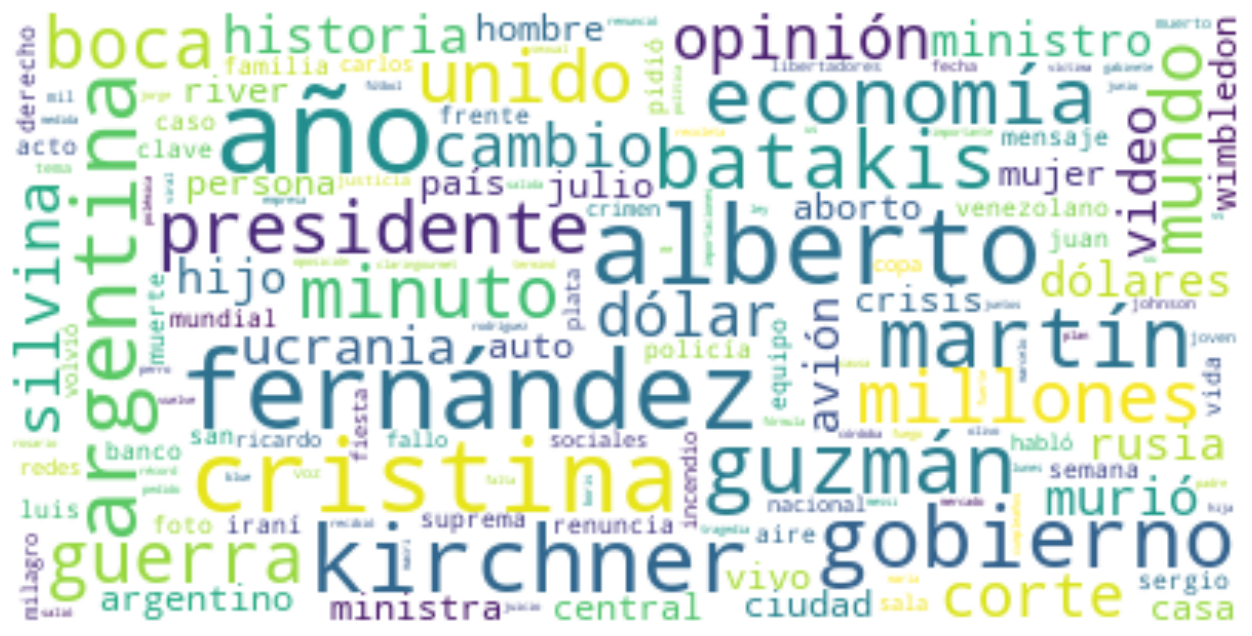

In [12]:
plt.figure(figsize=(18,8))
wordcloud = WordCloud(collocations=False,max_font_size=40,background_color='white',width=400,height=200).generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# 2-  Pre-Procesamiento

## Tokenizar

Una de las primeras tareas al momento de preprocesar el texto, es tomar una oración, la cual es un string, y descomponerla en una lista de tokens o palabras, que seran las unidades basicas de procesamiento.

In [13]:
lista = [tokenize(t) for t in df.full_text]

Una vez tokenizado el texto, pasamos de tener el siguiente texto:

In [14]:
df.full_text[17]

"Apareció un asteroide por sorpresa y 'rozará' la Tierra este jueves https://t.co/nnONNxHgH5"

A tener la siguiente lista de tokens:

In [15]:
list(lista[17])

['Apareció',
 'un',
 'asteroide',
 'por',
 'sorpresa',
 'y',
 'rozará',
 'la',
 'Tierra',
 'este',
 'jueves',
 'https',
 't',
 'co',
 'nnONNxHgH']

## Pasar a minuscula y sacar signos de puntuación

Tanto las mayusculas y minusculas como los signos de puntuación no aportan mucho contenido semántico. Por ejemplo, nos interesa que "reunión" o "reunion" sea la referencia a la misma palabra. Lo lo mismo sucede con "Reunión" y "reunión". 
Por este motivo, el siguiente paso es eliminar los signos de puntuación y llevar todas las palabras a minuscula. 

In [16]:
text_data = []
lista = [tokenize(t) for t in df.full_text]
for texto in lista:
    lower_tokens = [t.lower() for t in texto if t.isalpha()]
    text_data.append(lower_tokens)

In [17]:
text_data[17]

['apareció',
 'un',
 'asteroide',
 'por',
 'sorpresa',
 'y',
 'rozará',
 'la',
 'tierra',
 'este',
 'jueves',
 'https',
 't',
 'co',
 'nnonnxhgh']

## N-Gram

Existe una herramienta que a través del uso de métodos estádisticos nos permite encontrar N-Gramas. Esto nos permitirá entender dentro de los textos que terminos tales como "Rosario Central", "Rafa Nadal" o "Buenos Aires" son compuestos y tienen un solo contenido semántico.

In [18]:
bigram = gensim.models.Phrases(text_data, min_count = 5, threshold = 15) # a thresholds más grandes menos frases.
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [19]:
list(bigram_mod[text_data])

[['confesó',
  'la',
  'mano',
  'la',
  'imagen',
  'de',
  'matías_suárez',
  'y',
  'julián_álvarez',
  'hablando',
  'después',
  'del',
  'gol',
  'https',
  't',
  'co',
  'kyp',
  'ufqzmh'],
 ['el',
  'tenista_español',
  'debía',
  'enfrentar',
  'a',
  'kyrgios',
  'en',
  'las',
  'semis',
  'pero',
  'convocó',
  'una',
  'conferencia',
  'para',
  'explicar',
  'que',
  'deja',
  'el',
  'torneo',
  'más',
  'https',
  't',
  'co',
  'w',
  'skqdyofa',
  'https',
  't',
  'co',
  'z',
  'efmphx'],
 ['sergio_massa',
  'recibió',
  'a',
  'silvina_batakis',
  'y',
  'hablaron',
  'de',
  'la',
  'agenda',
  'legislativa',
  'https',
  't',
  'co',
  'j',
  'uuwxttrd'],
 ['una_mujer',
  'embarazada',
  'está',
  'presa',
  'por',
  'defenderse',
  'de',
  'su',
  'maltratador',
  'a',
  'días',
  'del',
  'parto',
  'le',
  'niegan',
  'la',
  'domiciliaria',
  'https',
  't',
  'co',
  'svzpkd',
  'zgm'],
 ['el',
  'flamante_dt',
  'de',
  'rosario_central',
  'volvió',
  'a'

## 3-  TF-IDF

Una de las formas que existen para scorear nuestras palabras utiizando su frecuencia es utilizando TF-IDF

In [20]:
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
dictionary = Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]
model = TfidfModel(corpus)  

In [21]:
i=17
print(model[corpus[i]])
print('\n')
print(corpus[i])
text_data[i]

[(0, np.float64(0.0017132445317090022)), (7, np.float64(0.0016039576456741331)), (11, np.float64(0.02828458219153646)), (15, np.float64(0.0016638809055554455)), (17, np.float64(0.03784148540824368)), (63, np.float64(0.0675516407906665)), (87, np.float64(0.07050510917384763)), (227, np.float64(0.27442265553816947)), (228, np.float64(0.4043566111324552)), (229, np.float64(0.16835654347606502)), (230, np.float64(0.2520526445723704)), (231, np.float64(0.4982904956698302)), (232, np.float64(0.4982904956698302)), (233, np.float64(0.2805456045797902)), (234, np.float64(0.28678622143943666))]


[(0, 1), (7, 1), (11, 1), (15, 1), (17, 1), (63, 1), (87, 1), (227, 1), (228, 1), (229, 1), (230, 1), (231, 1), (232, 1), (233, 1), (234, 1)]


['apareció',
 'un',
 'asteroide',
 'por',
 'sorpresa',
 'y',
 'rozará',
 'la',
 'tierra',
 'este',
 'jueves',
 'https',
 't',
 'co',
 'nnonnxhgh']

En el ejemplo anterior podemos ver como transofrmamos el texto original en una secuencia con TF-IDF. Para más información visitar: https://radimrehurek.com/gensim/models/tfidfmodel.html

# 4- Embeddings

In [22]:
from gensim.models.word2vec import Word2Vec

Entrenamos nuestro modelo de embeddings con una dimensión oculta de 30 dimensiones. Para mas información ver: https://radimrehurek.com/gensim/models/word2vec.html

In [23]:
# "window" es el tamaño de la ventana. windows = 10, usa 10 palabras a la izquierda y 10 palabras a la derecha
# "n_dim" es la dimension (i.e. el largo) de los vectores de word2vec
# "workers" es el numero de cores que usa en paralelo. Para aprovechar eso es necesario tener instalado Cython)
# "sample": word2vec filtra palabras que aparecen una fraccion mayor que "sample"
# "min_count": Word2vec filtra palabras con menos apariciones que  "min_count"
# "sg": para correr el Skipgram model (sg = 1), para correr el CBOW (sg = 0)
# para mas detalle ver: https://radimrehurek.com/gensim/models/word2vec.html
n_dim = 30
w2v_model = Word2Vec(text_data, vector_size=n_dim, workers=4, min_count = 5, window = 5, sample = 1e-3,negative=10,sg=1)

## Resultados

Una vez entrenado nuestro algoritmo podemos ver calcular la distancia entre palabras, es así como vemos que hay una mayor distancia entre "Aldosivi" y "Libertadores" que las que hay entre River y/o Boca, lo mismo sucede con "Ministro" y "Messi" y la palabra "Economía". Este fenomeno sucede ya que en un Word Embedding aquellas palabras que suelen aparecer en un mismo contexto tienden a encontrarse más cercanas en nuestro espacio N-dimensional.

In [24]:
print ("river-libertadores similarity:",w2v_model.wv.n_similarity(["river"], ["libertadores"]))
print ("boca-libertadores similarity:",w2v_model.wv.n_similarity(["boca"], ["libertadores"]) )
print ("aldosivi-libertadores similarity:",w2v_model.wv.n_similarity(["aldosivi"], ["libertadores"]) )
print("\n")

print ("ministro-economía similarity:",w2v_model.wv.n_similarity(["ministro"], ["economía"]) )
print ("messi-economía similarity:",w2v_model.wv.n_similarity(["messi"], ["economía"]) )

river-libertadores similarity: 0.783451
boca-libertadores similarity: 0.7326969
aldosivi-libertadores similarity: 0.41671237


ministro-economía similarity: 0.8203871
messi-economía similarity: 0.36665913


Por otro lado, podemos obtener cuales son las 25 palabras más similares a "libertadores" o "elecciones"

In [25]:
w2v_model.wv.most_similar(positive=["libertadores"], negative=[], topn=25)

[('revancha', 0.9063405394554138),
 ('copalibertadores', 0.904258131980896),
 ('octavos', 0.8939186334609985),
 ('ida', 0.8796896934509277),
 ('copa', 0.8758938908576965),
 ('conmebol', 0.8520326614379883),
 ('vélez', 0.8381244540214539),
 ('final', 0.8375827670097351),
 ('sudamericana', 0.8355167508125305),
 ('corinthians', 0.8350639343261719),
 ('fortaleza', 0.8245458006858826),
 ('eliminación', 0.8220700025558472),
 ('eliminado', 0.8194496035575867),
 ('llave', 0.8191726207733154),
 ('velez', 0.8149312734603882),
 ('monumental', 0.8021759390830994),
 ('maracaná', 0.7964211106300354),
 ('tolima', 0.7934147119522095),
 ('cacique', 0.7909861207008362),
 ('talleres', 0.7845562696456909),
 ('river', 0.7834509015083313),
 ('clasificación', 0.7809841632843018),
 ('colón', 0.7803401350975037),
 ('plate', 0.7779337763786316),
 ('pensando', 0.7775807976722717)]

In [26]:
w2v_model.wv.most_similar(positive=["elecciones"], negative=[], topn=15)

[('presidenciales', 0.9101907014846802),
 ('legislativas', 0.8951545357704163),
 ('próximas', 0.8849427103996277),
 ('colombia', 0.8788425922393799),
 ('balotaje', 0.8501607179641724),
 ('naciones', 0.8436134457588196),
 ('petro', 0.8185041546821594),
 ('américas', 0.7983243465423584),
 ('islas', 0.7911379933357239),
 ('izquierda', 0.7847086191177368),
 ('presidencia', 0.7805280685424805),
 ('francia', 0.7794323563575745),
 ('parlamento', 0.7788083553314209),
 ('macron', 0.7785258889198303),
 ('encuestas', 0.776682436466217)]

También podríamos ver esto de forma gráfica. En el siguiente ejemplo, veremos cuales son las palabras más similares a la palabra "guerra" dentro de nuestro conjunto de textos.

<Axes: >

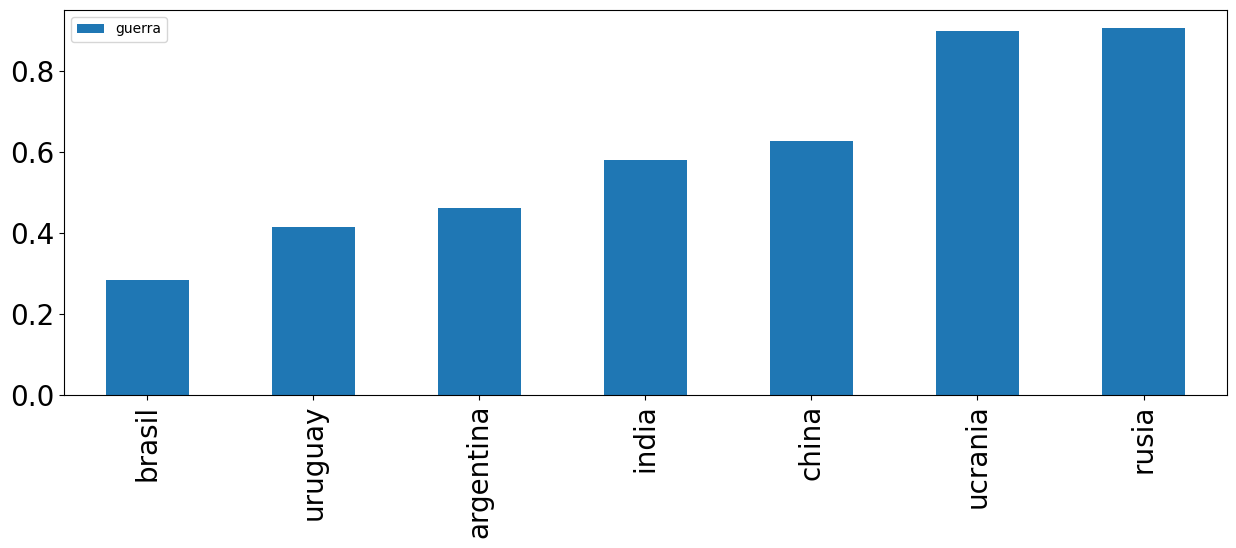

In [27]:
target_word= "guerra"
topicos = ["rusia","argentina","brasil","uruguay","china","india", "ucrania"]
similares = []
for word in topicos:
    similares.append(w2v_model.wv.n_similarity([target_word], [word]))
    
pd.DataFrame(similares,index = topicos,columns=[target_word]).sort_values(by=target_word).plot(kind="bar",figsize=(15,5), fontsize=20)

### Visualización de Embeddings

Nuestro word embedding fue entrenado utlizando todas las palabras de nuestros textos, y las mismas fueron llevadas a un espacio N-Dimensional, en nuestro caso 30 dimensiones. Para poder visualizarlas podemos tomar algun algoritmo de reducción de dimensionalidad y llevar este espacio de 30 dimensiones a 2.

In [28]:
p_sociedad = ['hambre','pobreza','industria','campo','fmi','crisis','elecciones','inseguridad','dinero']
p_paises = ["perú","bolivia","paraguay","uruguay","brasil","colombia",'chile','españa']
p_tecno = ["tecnología","internet","web",'facebook','instagram']
p_deporte = ['boca','river','independiente','racing','libertadores','tenis','sudamericana']
p_politicos = ["macri", 'cristina', 'alberto', 'vidal', 'kicillof','bolsonaro','trump','biden','larreta']
p_pandemia = ["covid", 'vacuna', 'sputnik', 'pandemia', 'coronavirus','cuarentena']
palabras =  p_paises + p_tecno + p_politicos+ p_sociedad + p_deporte + p_pandemia
colores = ["black"]*len(p_paises)+["red"]*len(p_tecno)+["orange"]*len(p_politicos)+["blue"]*len(p_sociedad)+["purple"]*len(p_deporte) +["green"]*len(p_pandemia)

In [29]:
# Armo una matriz de distancias
distancias=np.zeros((len(palabras),len(palabras))) #matriz cuadrada
for i,ti in enumerate(palabras):
    for j,tj in enumerate(palabras):
        distancias[i,j] = abs(1-w2v_model.wv.similarity(ti,tj))

In [30]:
# Reduccion de la dimensionalidad y visualizacion 
from sklearn.manifold import MDS
from sklearn.manifold import TSNE 
def visualize_embeddings(distancias,palabras,colores,perplexity):
    plt.figure(figsize=(35,8))
    # Reduccion de la dimensionalidad y visualizacion 
    mds = MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=123,
                       dissimilarity="precomputed", n_jobs=4)
    Y = mds.fit(distancias).embedding_
    plt.subplot(1,2,1)
    plt.scatter(Y[:, 0], Y[:, 1],color="black",s=3)
    for label, x, y, color in zip(palabras, Y[:, 0], Y[:, 1],colores):
        plt.annotate(label, xy=(x, y), xytext=(0, 0),color=color, textcoords='offset points',size=13)
    plt.title("MDS")

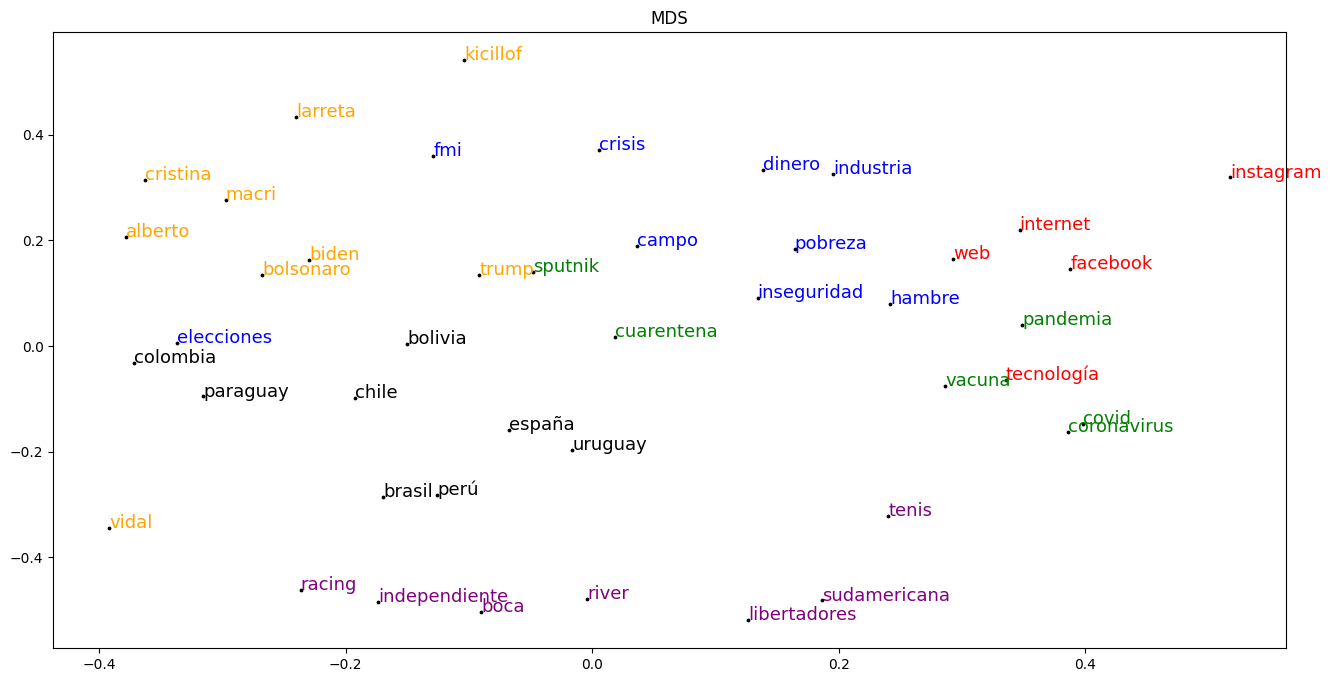

In [31]:
visualize_embeddings(distancias,palabras,colores,perplexity=10)

En la visualización podemos observar como palabras con significado similar aparecen juntas. 